# **Import libraries**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import keras
import tensorflow as tf
from keras import layers
from keras import models
from keras.datasets import mnist
from keras.utils import to_categorical
import seaborn as sns
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Activation, Dropout,AveragePooling2D, BatchNormalization, ZeroPadding2D
from keras.models import Sequential
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
import time
from keras.optimizers import RMSprop, Adam
from tabulate import tabulate


# **Import data**

import given dataset as trainset and testset

In [3]:
#
# This is a sample Notebook to demonstrate how to read "MNIST Dataset"
#
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img
        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

In [45]:
#
# Verify Reading Dataset via MnistDataloader class
#
%matplotlib inline
import random

#
# Set file paths based on added MNIST Datasets
#
input_path = '/content/drive/MyDrive/Datasets/mnist'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(X_train, Y_train), (X_test, Y_test) = mnist_dataloader.load_data()

In [46]:
print("Type of X_train:", type(X_train))
print("Type of X_test:", type(X_test))
print("Type of Y_train:", type(Y_train))
print("Type of Y_test:", type(Y_test))

Type of X_train: <class 'list'>
Type of X_test: <class 'list'>
Type of Y_train: <class 'array.array'>
Type of Y_test: <class 'array.array'>


In [47]:
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)
print("X_train shape", X_train.shape)
print("Y_train shape", Y_train.shape)
print("X_test shape", X_test.shape)
print("Y_test shape", Y_test.shape)

X_train shape (60000, 28, 28)
Y_train shape (60000,)
X_test shape (10000, 28, 28)
Y_test shape (10000,)


In [48]:
Y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

**Thống kê số lượng hình ảnh theo nhãn của 2 tập**

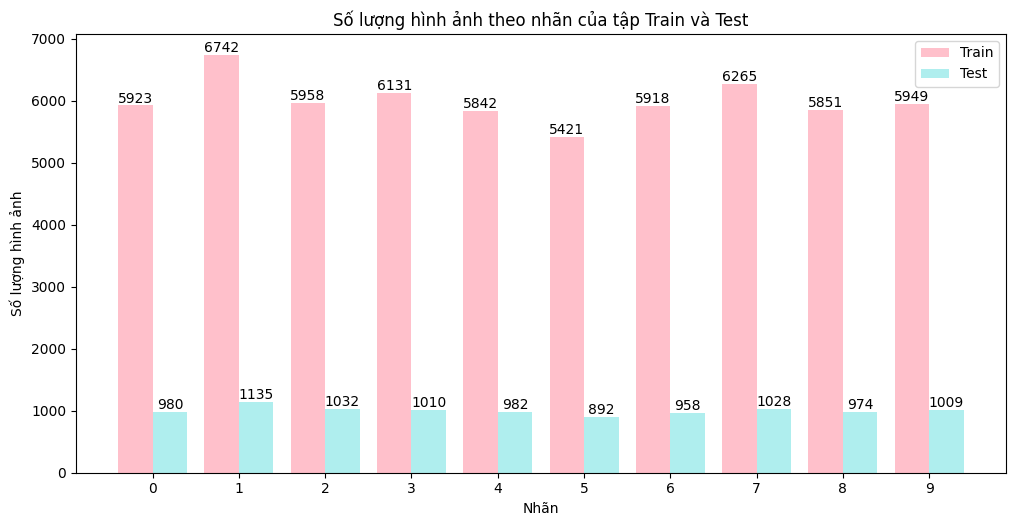

In [49]:
# Tính toán số lượng hình ảnh trong mỗi nhóm lớp cho cả tập train và tập test
train_class_counts = np.bincount(Y_train)
test_class_counts = np.bincount(Y_test)

plt.figure(figsize=(12, 5.7))
train_bars = plt.bar(np.arange(10) - 0.2, train_class_counts, color='pink', width=0.4, label='Train')
test_bars = plt.bar(np.arange(10) + 0.2, test_class_counts, color='paleturquoise', width=0.4, label='Test')
plt.xlabel('Nhãn')
plt.ylabel('Số lượng hình ảnh')
plt.title('Số lượng hình ảnh theo nhãn của tập Train và Test')
plt.xticks(range(10))
plt.legend()

for bar, count in zip(train_bars, train_class_counts):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height(),
             f'{count}',
             ha='center',
             va='bottom')


for bar, count in zip(test_bars, test_class_counts):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height(),
             f'{count}',
             ha='center',
             va='bottom')
plt.savefig("count_im_each_class.png")
plt.show()


**Hiển thị ngẫu nhiên 20 hình thuộc tập dataset (Train và Test)**

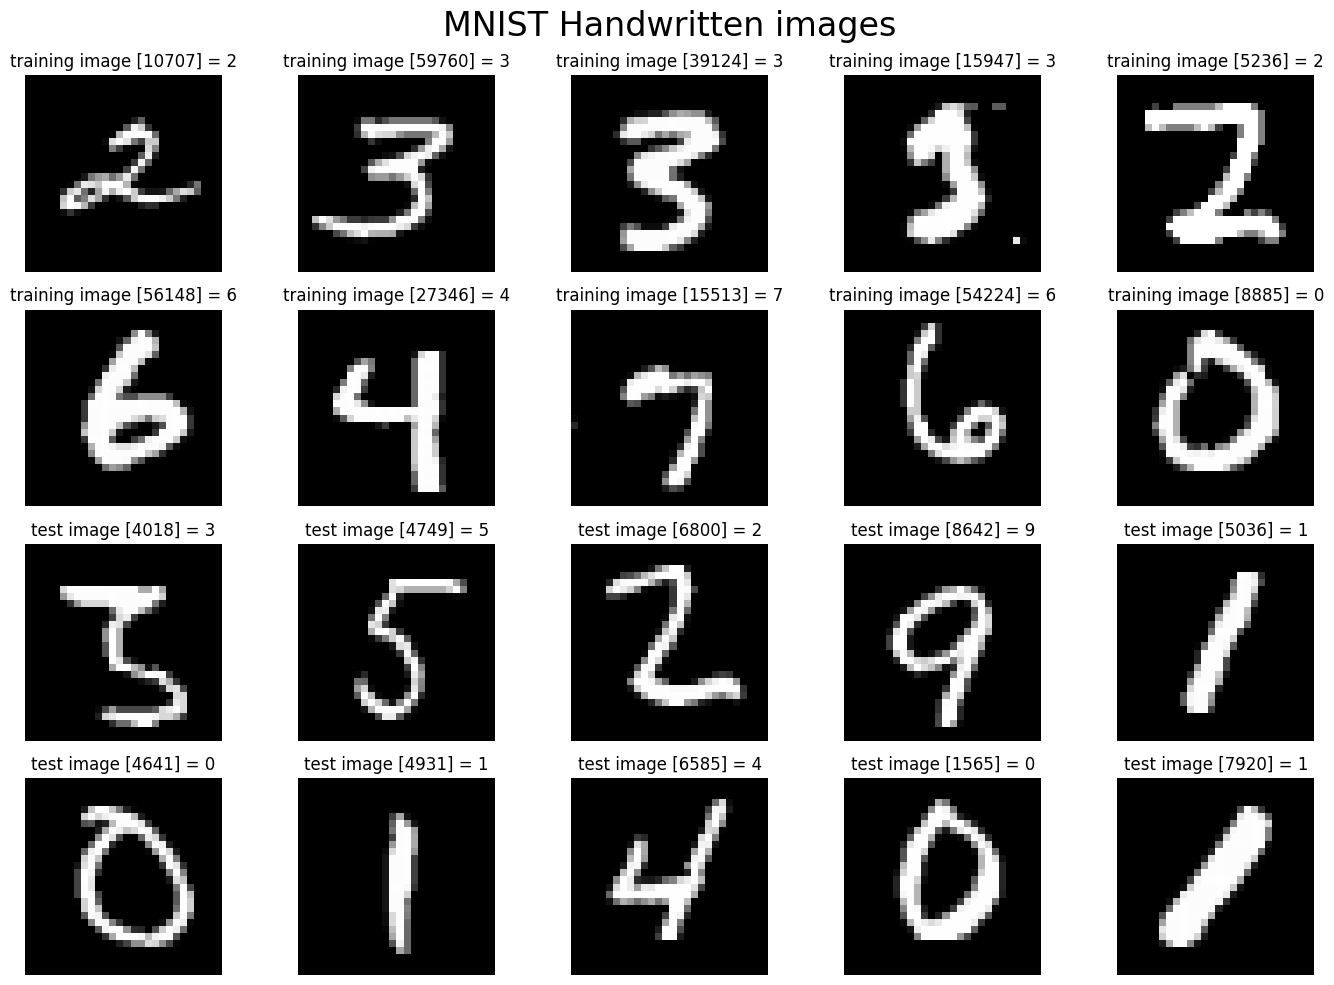

In [50]:
import random
import matplotlib.pyplot as plt

images_2_show = []
titles_2_show = []

# Quét random 10 tấm trong tập Xtrain, Ytrain
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(X_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(Y_train[r]))

# Quét random 10 tấm trong tập Xtest, Ytest
for i in range(0, 10):
    r = random.randint(1, 10000)
    images_2_show.append(X_test[r])
    titles_2_show.append('test image [' + str(r) + '] = ' + str(Y_test[r]))

# Kích thước của output
plt.figure(figsize=(14, 10))
plt.suptitle('MNIST Handwritten images', fontsize=24)

# Duyệt qua từng hình ảnh trong danh sách
for i, image in enumerate(images_2_show):
    plt.subplot(4, 5, i + 1)  # Thêm subplot vào vị trí tương ứng
    plt.imshow(image, cmap='gray')  # Hiển thị hình ảnh từ danh sách
    plt.title(titles_2_show[i])
    plt.axis('off')  # Tắt trục

plt.tight_layout()
plt.savefig("plot20mnistimage.png")  # Lưu hình vào file
plt.show()

# **Preprocessing**

Tiền xử lý dữ liệu MNIST để đưa vào mô hình CNN bằng cách thêm một chiều mới cho kênh màu, chuẩn hóa dữ liệu và biểu diễn nhãn lớp dưới dạng one-hot encoding để huấn luyện mô hình.

* B1: Đối với CNN, chúng ta cần một chiều cuối để biểu diễn kênh màu. Trong TH này, chỉ có một kênh màu vì ảnh đen trắng nên chiều cuối = 1. Đối với ảnh màu, kích thước sẽ là 3 cho các kênh màu RGB. Chuyển đổi dữ liệu về dạng số thực 32-bit cho bước chuẩn hóa dữ liệu.

* B2: Chuẩn hóa bằng cách chia tất cả các giá trị pixel cho 255 để đưa giá trị về khoảng từ 0 đến 1.

* B3: Y_train, Y_test chuyển nhãn lớp từ dạng số nguyên thành biểu diễn one-hot encoding. Ví dụ, nếu nhãn lớp ban đầu là 3, one-hot encoding biểu diễn thành vector [0, 0, 0, 1, 0, 0, 0, 0, 0, 0], có nghĩa chỉ có phần tử thứ 3 là 1 và phần tử còn lại là 0.

In [52]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255
Y_train = to_categorical(Y_train, num_classes=10)
Y_test = to_categorical(Y_test, num_classes=10)

**Từ tập dữ liệu đã preprocess, ta chia tiếp 80% trainset ban đầu thành trainset mới, 20% còn lại là validset.**

In [53]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

print("Shape của X_train:", X_train.shape)
print("Shape của X_valid:", X_valid.shape)
print("Shape của Y_train:", Y_train.shape)
print("Shape của Y_valid:", Y_valid.shape)

Shape của X_train: (48000, 28, 28, 1)
Shape của X_valid: (12000, 28, 28, 1)
Shape của Y_train: (48000, 10)
Shape của Y_valid: (12000, 10)


**Tỉ lệ của 3 tập trong dataset**

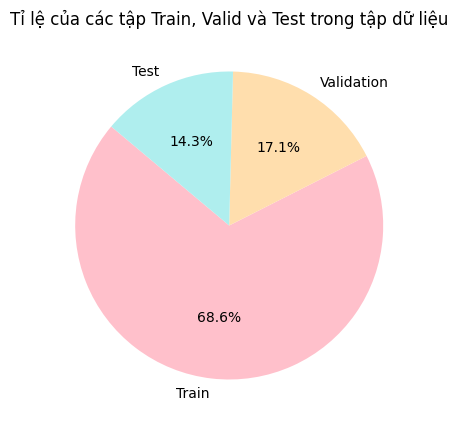

In [54]:
# Tính toán phần trăm cho từng tập dữ liệu
percent_train = (X_train.shape[0] / (X_train.shape[0] + X_test.shape[0] + X_valid.shape[0])) * 100
percent_valid = (X_valid.shape[0] / (X_train.shape[0] + X_test.shape[0] + X_valid.shape[0])) * 100
percent_test = (X_test.shape[0] / (X_train.shape[0] + X_test.shape[0] + X_valid.shape[0])) * 100

sizes = [percent_train, percent_valid, percent_test]
labels = ['Train', 'Validation', 'Test']
colors = ['pink', 'navajowhite', 'paleturquoise']  # Màu pastel đỏ, xanh dương và xanh lá cây

plt.figure(figsize=(6, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Tỉ lệ của các tập Train, Valid và Test trong tập dữ liệu')

plt.savefig("percent_im_each_set.png")
plt.show()


In [26]:
r = -4*np.random.rand()
lr = 10**r
lr

0.00012718168142631712

# **Original Lenet5**

In [55]:
def LeNet5(input_shape=(28, 28, 1), classes=10):

    model = Sequential()

    # Layer C1 + S2
    model.add(Conv2D(filters=6, strides=(1,1), kernel_size=(5,5), activation='tanh', padding='same',
                     input_shape=input_shape, name='convolution_1'))
    model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2)))
    # -------------------------------- #
    # Layer C3 + S4
    model.add(Conv2D(filters=16, strides=(1,1), kernel_size=(5,5), activation='tanh',
                     name='convolution_2'))
    model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2)))
    # -------------------------------- #
    # Layer F5
    model.add(Dense(units=120,activation='tanh', name='fully_connected_1'))
    model.add(Flatten(name='flatten'))
    # -------------------------------- #
    # Layer F6
    model.add(Dense(units=84, activation='tanh', name='fully_connected_2'))
    # -------------------------------- #
    # Layer Output
    model.add(Dense(units=10, activation='softmax', name='output'))

    return model

LeNet5Model = LeNet5(input_shape = (28, 28, 1), classes = 10)
LeNet5Model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convolution_1 (Conv2D)      (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d_4 (Avera  (None, 14, 14, 6)         0         
 gePooling2D)                                                    
                                                                 
 convolution_2 (Conv2D)      (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_5 (Avera  (None, 5, 5, 16)          0         
 gePooling2D)                                                    
                                                                 
 fully_connected_1 (Dense)   (None, 5, 5, 120)         2040      
                                                                 
 flatten (Flatten)           (None, 3000)             

In [57]:
LeNet5Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist2 = LeNet5Model.fit(X_train, Y_train, batch_size=32, epochs=100, validation_data=(X_valid, Y_valid), verbose=1)

Epoch 1/100
1500/1500 [==============================] - 9s 5ms/step - loss: 0.2456 - accuracy: 0.9272 - val_loss: 0.1289 - val_accuracy: 0.9634
Epoch 2/100
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0975 - accuracy: 0.9703 - val_loss: 0.0742 - val_accuracy: 0.9788
Epoch 3/100
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0645 - accuracy: 0.9798 - val_loss: 0.0705 - val_accuracy: 0.9777
Epoch 4/100
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0507 - accuracy: 0.9844 - val_loss: 0.0581 - val_accuracy: 0.9824
Epoch 5/100
1500/1500 [==============================] - 8s 6ms/step - loss: 0.0403 - accuracy: 0.9876 - val_loss: 0.0546 - val_accuracy: 0.9841
Epoch 6/100
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0348 - accuracy: 0.9891 - val_loss: 0.0511 - val_accuracy: 0.9852
Epoch 7/100
1500/1500 [==============================] - 8s 6ms/step - loss: 0.0308 - accuracy: 0.9902 - val_loss: 0.0480 - val_a

In [58]:
from sklearn.metrics import accuracy_score, mean_absolute_error
mae2 = round(mean_absolute_error(hist2.history['accuracy'], hist2.history['val_accuracy']), 5)

acc2_val = np.average(hist2.history['val_accuracy'])
loss2_val = np.average(hist2.history['val_loss'])

acc2_train = np.average(hist2.history['accuracy'])
loss2_train = np.average(hist2.history['loss'])

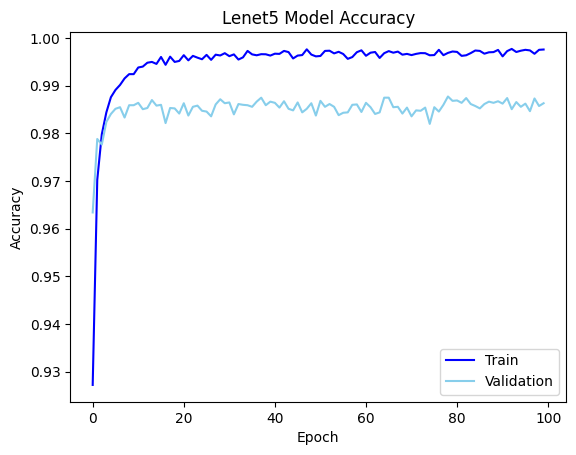

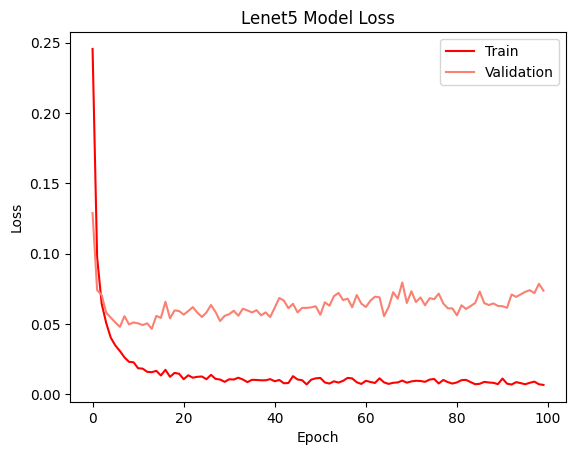

In [61]:
plt.plot(hist2.history['accuracy'], label='Train', color='blue')
plt.plot(hist2.history['val_accuracy'], label='Validation', color='skyblue')
plt.title('Lenet5 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(hist2.history['loss'], label='Train', color='red')
plt.plot(hist2.history['val_loss'], label='Validation', color='salmon')
plt.title('Lenet5 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Modified Lenet Model**


- Thêm L2 regularization vào 3 layer có parameter lớn nhất: Conv_2,FC1, FC2

- Thêm BatchNormalization ở giữa MaxPooling và Activation

- Thêm 1 Dropout 0.25 trước khi Flatten và 1 Dropout 0.5 trước lớp FC cuối



In [86]:
def my_lenet5(input_shape=(28, 28, 1), classes=10):

    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size = (3,3), strides=1, input_shape=input_shape, name='conv_1'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='max_pool_1'))
    model.add(BatchNormalization(name='batchnorm_1'))
    model.add(Activation("relu", name='activation_1'))
    # -------------------------------- #
    model.add(Conv2D(filters=64, kernel_size =3, strides= 1, kernel_regularizer=l2(0.0005), name='conv_2'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name='max_pool_2'))
    model.add(BatchNormalization(name='batchnorm_2'))
    model.add(Activation("relu", name='activation_2'))
    # -------------------------------- #
    model.add(Dropout(0.25, name='dropout_1'))
    model.add(Flatten(name='flatten'))
    # -------------------------------- #
    model.add(Dense(units=256, name='fc_1', kernel_regularizer=l2(0.0005),))
    model.add(BatchNormalization(name='batchnorm_3'))
    model.add(Activation("relu", name='activation_3'))
    # -------------------------------- #
    model.add(Dense(units=128, name='fc_2', kernel_regularizer=l2(0.0005),))
    model.add(BatchNormalization(name='batchnorm_4'))
    model.add(Activation("relu", name='activation_4'))
    # -------------------------------- #
    model.add(Dense(units=84, name='fc_3'))
    model.add(BatchNormalization(name='batchnorm_5'))
    model.add(Activation("relu", name='activation_5'))
    # -------------------------------- #
    model.add(Dropout(0.5, name='dropout_2'))
    model.add(Dense(units=10, activation='softmax', name='output'))

    return model
my_model = my_lenet5(input_shape = (28, 28, 1), classes = 10)
my_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pool_1 (MaxPooling2D)   (None, 13, 13, 32)        0         
                                                                 
 batchnorm_1 (BatchNormaliz  (None, 13, 13, 32)        128       
 ation)                                                          
                                                                 
 activation_1 (Activation)   (None, 13, 13, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 11, 11, 64)        18496     
                                                                 
 max_pool_2 (MaxPooling2D)   (None, 5, 5, 64)          0         
                                                     

**Compile mô hình biến thể sử dụng optimizer Adam**

In [88]:
optimizer_adam = Adam(learning_rate=lr)
my_model.compile(optimizer=optimizer_adam, loss='categorical_crossentropy', metrics=['accuracy'])

hist1_adam = my_model.fit(X_train, Y_train, batch_size=64, epochs=100, validation_data=(X_valid, Y_valid), verbose=1)

Epoch 1/100
750/750 [==============================] - 8s 7ms/step - loss: 0.4579 - accuracy: 0.9631 - val_loss: 0.3341 - val_accuracy: 0.9847
Epoch 2/100
750/750 [==============================] - 6s 8ms/step - loss: 0.3656 - accuracy: 0.9758 - val_loss: 0.2900 - val_accuracy: 0.9893
Epoch 3/100
750/750 [==============================] - 5s 7ms/step - loss: 0.3141 - accuracy: 0.9811 - val_loss: 0.2612 - val_accuracy: 0.9897
Epoch 4/100
750/750 [==============================] - 6s 8ms/step - loss: 0.2781 - accuracy: 0.9838 - val_loss: 0.2371 - val_accuracy: 0.9901
Epoch 5/100
750/750 [==============================] - 5s 7ms/step - loss: 0.2478 - accuracy: 0.9859 - val_loss: 0.2150 - val_accuracy: 0.9908
Epoch 6/100
750/750 [==============================] - 6s 8ms/step - loss: 0.2224 - accuracy: 0.9879 - val_loss: 0.1975 - val_accuracy: 0.9913
Epoch 7/100
750/750 [==============================] - 6s 8ms/step - loss: 0.2021 - accuracy: 0.9891 - val_loss: 0.1819 - val_accuracy: 0.9926

In [89]:
my_model.save("lenet_mod_adam.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Compile mô hình biến thể sử dụng optimizer RMSProp**

In [82]:
optimizer_rmsprop = RMSprop(learning_rate=lr)
my_model.compile(optimizer=optimizer_rmsprop, loss='categorical_crossentropy', metrics=['accuracy'])

hist1_rmsprop = my_model.fit(X_train, Y_train, batch_size=64,epochs=100, validation_data=(X_valid, Y_valid), verbose=1)

Epoch 1/100
750/750 [==============================] - 8s 8ms/step - loss: 0.8695 - accuracy: 0.8475 - val_loss: 0.4064 - val_accuracy: 0.9758
Epoch 2/100
750/750 [==============================] - 6s 8ms/step - loss: 0.4340 - accuracy: 0.9664 - val_loss: 0.3237 - val_accuracy: 0.9845
Epoch 3/100
750/750 [==============================] - 5s 6ms/step - loss: 0.3523 - accuracy: 0.9772 - val_loss: 0.2822 - val_accuracy: 0.9884
Epoch 4/100
750/750 [==============================] - 5s 7ms/step - loss: 0.3010 - accuracy: 0.9811 - val_loss: 0.2524 - val_accuracy: 0.9891
Epoch 5/100
750/750 [==============================] - 5s 7ms/step - loss: 0.2663 - accuracy: 0.9840 - val_loss: 0.2275 - val_accuracy: 0.9900
Epoch 6/100
750/750 [==============================] - 5s 7ms/step - loss: 0.2369 - accuracy: 0.9860 - val_loss: 0.2139 - val_accuracy: 0.9888
Epoch 7/100
750/750 [==============================] - 6s 8ms/step - loss: 0.2128 - accuracy: 0.9872 - val_loss: 0.1890 - val_accuracy: 0.9905

In [72]:
my_model.save("lenet_mod_rmsprop.h5")

**So sánh MAE của model modified Lenet5 với optimizer RMSProp và Adam**

In [90]:
mae1_rmsprop = round(mean_absolute_error(hist1_rmsprop.history['accuracy'], hist1_rmsprop.history['val_accuracy']), 5)
mae1_adam = round(mean_absolute_error(hist1_adam.history['accuracy'], hist1_adam.history['val_accuracy']),5)

acc12_rmsprop = np.average(hist1_rmsprop.history['val_accuracy'])
acc12_adam = np.average(hist1_adam.history['val_accuracy'])
loss12_rmsprop = np.average(hist1_rmsprop.history['val_loss'])
loss12_adam = np.average(hist1_adam.history['val_loss'])

acc11_rmsprop = np.average(hist1_rmsprop.history['accuracy'])
acc11_adam = np.average(hist1_adam.history['accuracy'])
loss11_rmsprop = np.average(hist1_rmsprop.history['loss'])
loss11_adam = np.average(hist1_adam.history['loss'])


In [91]:
result = [["Modified Lenet5 with RMSProp", acc11_rmsprop, loss11_rmsprop, acc12_rmsprop, loss12_rmsprop, mae1_rmsprop],
    ["Modified Lenet5 with Adam", acc11_adam, loss11_adam, acc12_adam, loss12_adam, mae1_adam]]

# Tiêu đề cột
headers = ["Model", "Train Acc", "Train Loss", "Valid Acc", "Valid Loss", "MAE"]
print(tabulate(result, headers=headers, tablefmt="pipe"))

| Model                        |   Train Acc |   Train Loss |   Valid Acc |   Valid Loss |     MAE |
|:-----------------------------|------------:|-------------:|------------:|-------------:|--------:|
| Modified Lenet5 with RMSProp |    0.99249  |    0.0830657 |    0.991617 |    0.0950359 | 0.00463 |
| Modified Lenet5 with Adam    |    0.995164 |    0.0743829 |    0.992432 |    0.0878576 | 0.00405 |


**Plot kết quả của 2 quá trình compile với 2 hàm optimizer Adam vs RMSProp**

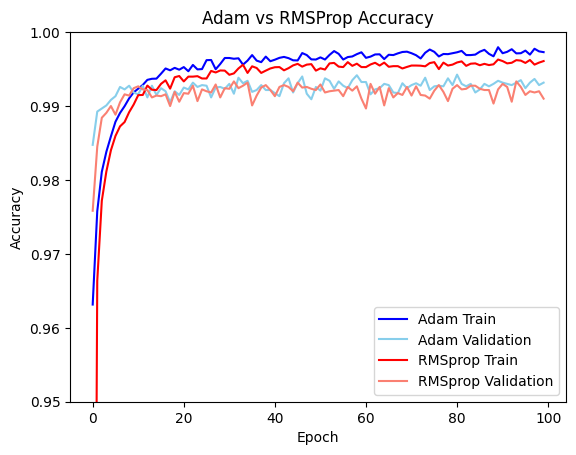

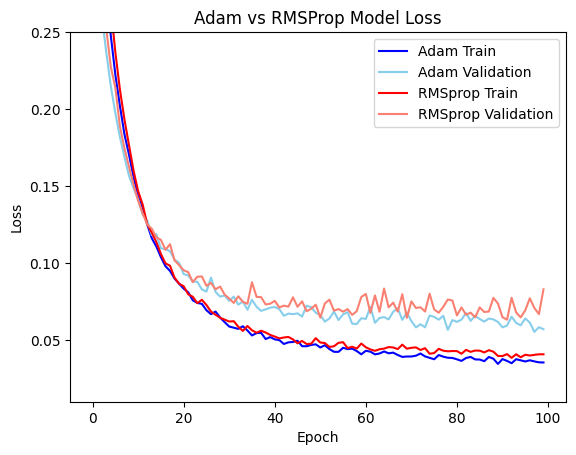

In [118]:
#PLOT SO SÁNH GIỮA RMSPROP VÀ ADAM
plt.plot(hist1_adam.history['accuracy'], label='Adam Train', color='blue')
plt.plot(hist1_adam.history['val_accuracy'], label='Adam Validation', color='skyblue')
plt.plot(hist1_rmsprop.history['accuracy'], label='RMSprop Train', color='red')
plt.plot(hist1_rmsprop.history['val_accuracy'], label='RMSprop Validation', color='salmon')
plt.title('Adam vs RMSProp Accuracy')
plt.ylim(0.95, 1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(hist1_adam.history['loss'], label='Adam Train', color='blue')
plt.plot(hist1_adam.history['val_loss'], label='Adam Validation', color='skyblue')
plt.plot(hist1_rmsprop.history['loss'], label='RMSprop Train', color='red')
plt.plot(hist1_rmsprop.history['val_loss'], label='RMSprop Validation', color='salmon')
plt.title('Adam vs RMSProp Model Loss')
plt.ylim(0.01, 0.25)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Mô hình Modified Lenet5 với hàm tối ưu Adam có giá trị MAE nhỏ hơn.**

# **Select best performance model**

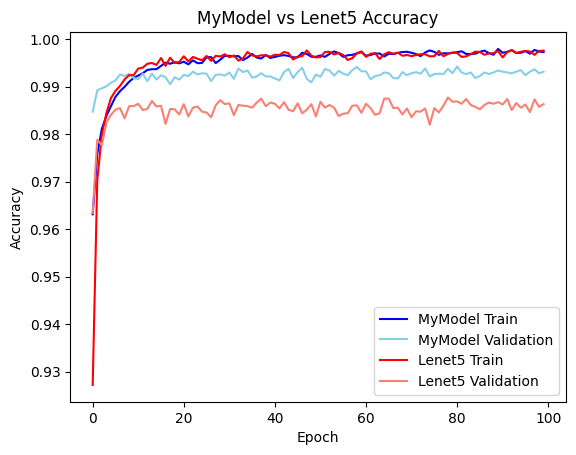

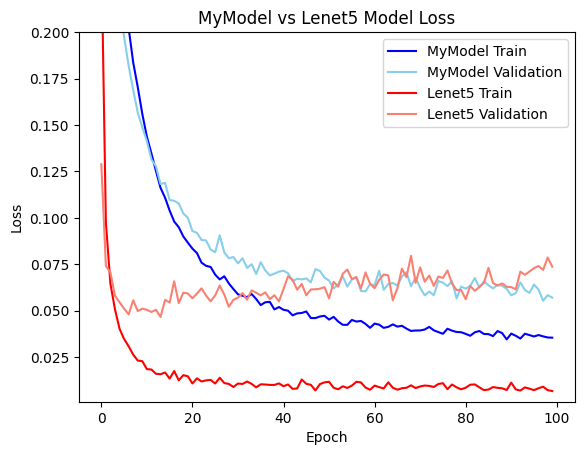

In [114]:
plt.plot(hist1_adam.history['accuracy'], label='MyModel Train', color='blue')
plt.plot(hist1_adam.history['val_accuracy'], label='MyModel Validation', color='skyblue')
plt.plot(hist2.history['accuracy'], label='Lenet5 Train', color='red')
plt.plot(hist2.history['val_accuracy'], label='Lenet5 Validation', color='salmon')
plt.title('MyModel vs Lenet5 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(hist1_adam.history['loss'], label='MyModel Train', color='blue')
plt.plot(hist1_adam.history['val_loss'], label='MyModel Validation', color='skyblue')
plt.plot(hist2.history['loss'], label='Lenet5 Train', color='red')
plt.plot(hist2.history['val_loss'], label='Lenet5 Validation', color='salmon')
plt.title('MyModel vs Lenet5 Model Loss')
plt.ylim(0.001, 0.2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Đánh giá hiệu suất của mô hình LeNet5 và LeNet5 cải tiến**

In [103]:
from tabulate import tabulate

test_scores1 = my_model.evaluate(X_valid, Y_valid, verbose=1)

test_scores2 = LeNet5Model.evaluate(X_valid, Y_valid, verbose=1)

result = [["Modified Lenet5", test_scores1[1], test_scores1[0]],
    ["Lenet5", test_scores2[1], test_scores2[0]]]

# Tiêu đề cột
headers = ["Model", "Accuracy", "Loss"]

# In bảng
print(tabulate(result, headers=headers, tablefmt="pipe"))

375/375 [==============================] - 1s 4ms/step - loss: 0.0737 - accuracy: 0.9863
| Model           |   Accuracy |      Loss |
|:----------------|-----------:|----------:|
| Modified Lenet5 |   0.993167 | 0.0570735 |
| Lenet5          |   0.986333 | 0.073718  |


In [102]:
test_scores2 = my_model.evaluate(X_test, Y_test, verbose = 2)
test_scores2

313/313 - 1s - loss: 0.0528 - accuracy: 0.9940 - 1s/epoch - 4ms/step


[0.05279693007469177, 0.9940000176429749]

# **Making prediction**

In [104]:
y_pred = my_model.predict(X_test, batch_size=64)

157/157 [==============================] - 0s 2ms/step


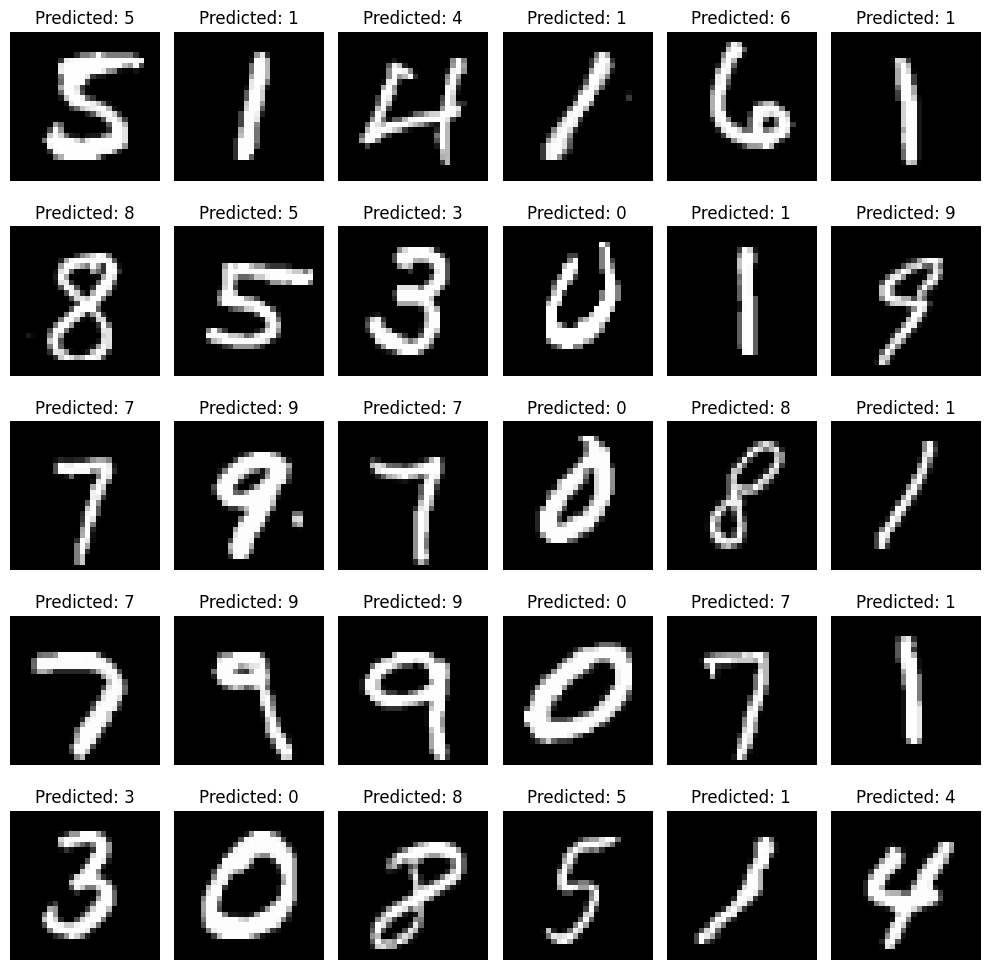

In [105]:
import random

# Định nghĩa số lượng hàng và cột trong ma trận 5x6
num_rows = 5
num_cols = 6

plt.figure(figsize=(10, 10))  # Thiết lập kích thước của hình tổng thể

# Tạo một danh sách các chỉ mục ngẫu nhiên từ mảng y_pred
random_indices = random.sample(range(len(y_pred)), num_rows*num_cols)

# Duyệt qua từng chỉ mục trong danh sách ngẫu nhiên
for idx, index in enumerate(random_indices):
    probability = y_pred[index]
    predicted_class = probability.argmax()  # Lấy index của lớp có xác suất cao nhất
    plt.subplot(num_rows, num_cols, idx + 1)  # Thêm subplot vào vị trí tương ứng trong ma trận
    plt.imshow(X_test[index], cmap='gray')  # Hiển thị hình ảnh từ tập dữ liệu
    plt.title('Predicted: ' + str(predicted_class))
    plt.axis('off')  # Tắt trục

plt.tight_layout()  # Điều chỉnh layout
plt.savefig("prediction.png")
plt.show()

In [106]:
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(Y_test, axis=1)
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin, digits=4))

              precision    recall  f1-score   support

           0     0.9949    0.9980    0.9964       980
           1     0.9947    0.9982    0.9965      1135
           2     0.9904    0.9990    0.9947      1032
           3     0.9921    0.9970    0.9946      1010
           4     0.9909    0.9959    0.9934       982
           5     0.9933    0.9910    0.9921       892
           6     0.9979    0.9885    0.9932       958
           7     0.9941    0.9883    0.9912      1028
           8     0.9979    0.9949    0.9964       974
           9     0.9940    0.9881    0.9911      1009

    accuracy                         0.9940     10000
   macro avg     0.9940    0.9939    0.9940     10000
weighted avg     0.9940    0.9940    0.9940     10000



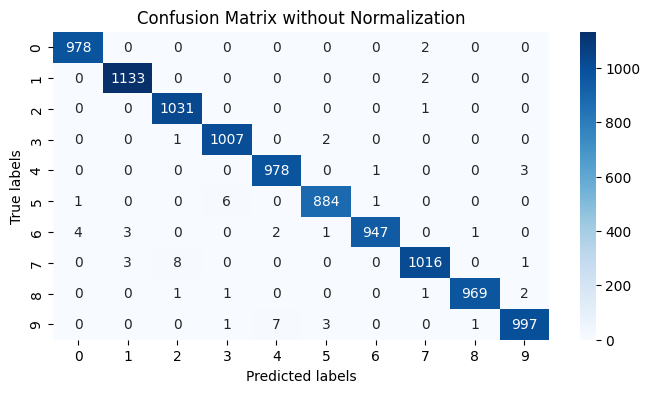

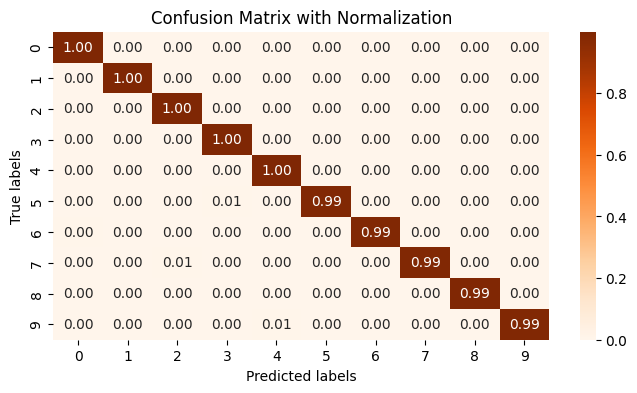

In [108]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Tính toán confusion matrix không chuẩn hóa
cm = confusion_matrix(y_test_bin, y_pred_bin)
plt.figure(figsize=(8, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')  # Biểu đồ không chuẩn hóa
plt.title('Confusion Matrix without Normalization')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

plt.savefig("cm1.png")
plt.show()

# Tính toán confusion matrix có chuẩn hóa
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 4))
sns.heatmap(cm_normalized, annot=True, cmap='Oranges', fmt='.2f')  # Biểu đồ có chuẩn hóa
plt.title('Confusion Matrix with Normalization')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

plt.savefig("cm1_norm.png")
plt.show()


In [109]:
accuracy = accuracy_score(y_test_bin, y_pred_bin)
print("Độ chính xác của mô hình Lenet5 cải tiến khi phân loại tập test là: \n",accuracy )

Độ chính xác của mô hình Lenet5 cải tiến khi phân loại tập test là: 
 0.994


157/157 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0     0.9818    0.9898    0.9858       980
           1     0.9886    0.9938    0.9912      1135
           2     0.9874    0.9893    0.9884      1032
           3     0.9871    0.9861    0.9866      1010
           4     0.9868    0.9919    0.9893       982
           5     0.9866    0.9877    0.9871       892
           6     0.9895    0.9843    0.9869       958
           7     0.9902    0.9796    0.9848      1028
           8     0.9796    0.9867    0.9831       974
           9     0.9890    0.9772    0.9831      1009

    accuracy                         0.9867     10000
   macro avg     0.9867    0.9866    0.9866     10000
weighted avg     0.9867    0.9867    0.9867     10000

Độ chính xác của mô hình Lenet5 khi phân loại tập test là: 
 0.9867


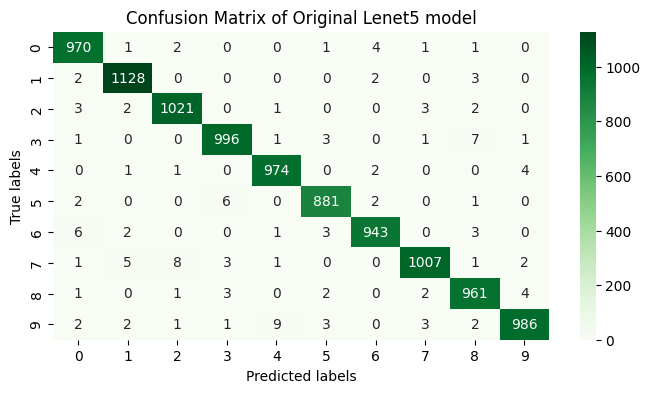

In [110]:
y_pred2 = LeNet5Model.predict(X_test, batch_size=64)
y_pred_bin2 = np.argmax(y_pred2, axis=1)
print(classification_report(y_test_bin, y_pred_bin2, digits=4))
print("Độ chính xác của mô hình Lenet5 khi phân loại tập test là: \n", accuracy_score(y_test_bin, y_pred_bin2))


# Tính toán confusion matrix không chuẩn hóa
cm2 = confusion_matrix(y_test_bin, y_pred_bin2)
plt.figure(figsize=(8, 4))
sns.heatmap(cm2, annot=True, cmap='Greens', fmt='d')  # Biểu đồ không chuẩn hóa
plt.title('Confusion Matrix of Original Lenet5 model')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

plt.savefig("cm2.png")
plt.show()